# The Butterworth & Lanczos Filters
#### by Elizabeth Barnes

Demonstration of how to code and apply (and interpret) Butterworth and Lanczos filters. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12.0/2, 8.0/2)

# specify whether running on Colab or locally
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = True


### Define a function to determine the Lanczos Filter weights to use later in the code

In [0]:
# LANCZOS FILTER
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.

    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
        
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    
    return w[1:-1]

### Butterworth Filters

In [0]:
# define a frequency array
freq = np.arange(0.,0.51,0.01)

# define omega (radial frequency) and the omega cutoff for filtering
omega = 2.*np.pi*freq
omega_c = .25*2*np.pi

#### Response function of a Butterworth filter

Next, we will calculate the squared response functions of Butterworth filters of different _orders_ (N=4,9,30). These will be defined from theory (see lecture notes). The figure below shows what these response functions look like in frequency space.

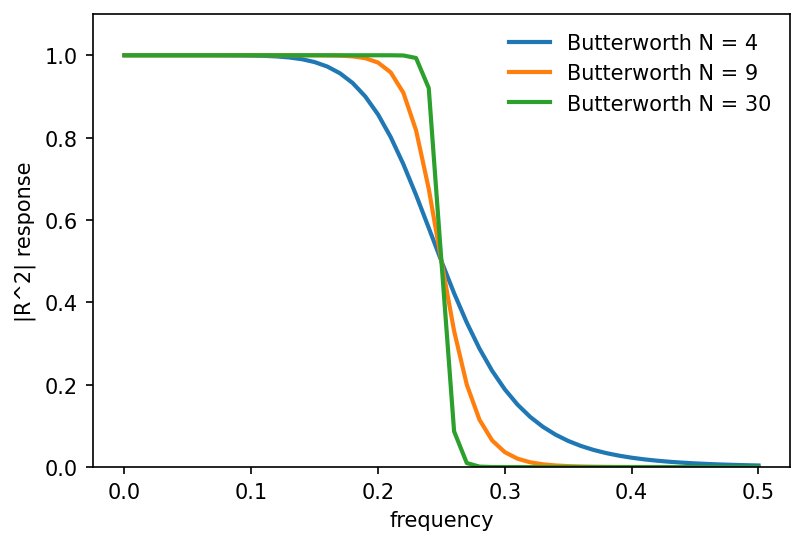

In [14]:
#**********TRY TO MODIFY**************
# Modify the "N" values below
#*************************************
plt.figure()

N = 4
R2 = 1./(1. + (omega/omega_c)**(2*N))
plt.plot(freq,R2,'-',linewidth = 2, label = 'Butterworth N = ' + str(N))

N = 9
R2 = 1./(1. + (omega/omega_c)**(2*N))
plt.plot(freq,R2,'-',linewidth = 2, label = 'Butterworth N = ' + str(N))

N = 30
R2 = 1./(1. + (omega/omega_c)**(2*N))
plt.plot(freq,R2,'-',linewidth = 2, label = 'Butterworth N = ' + str(N))

plt.xlabel('frequency')
plt.ylabel('|R^2| response')
plt.legend(frameon = False)

plt.ylim(0,1.1)
plt.show()

#### Impulse response function of a Butterworth filter
The impulse response shows how a filter spreads the influence of a single observation (time) across the other times. It is as easy as running an array of all zeros and one leading "1" through the filter and plotting the result.

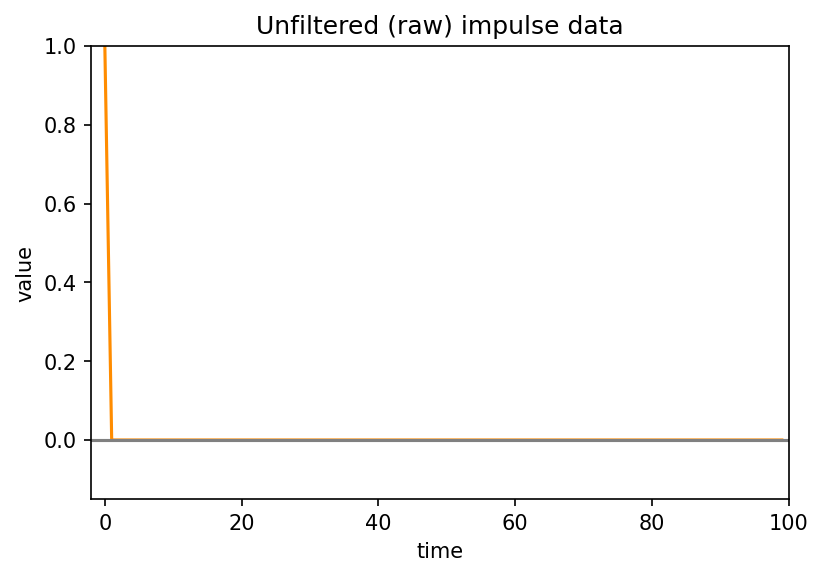

In [10]:
x = np.zeros((100,))
x[0] = 1.

plt.figure()
plt.plot(x, color = 'darkorange')
plt.axhline(y=0,color='gray')
plt.ylim(-.15,1.)
plt.xlim(-2,100)
plt.xlabel('time')
plt.ylabel('value')
plt.title('Unfiltered (raw) impulse data')
plt.show()

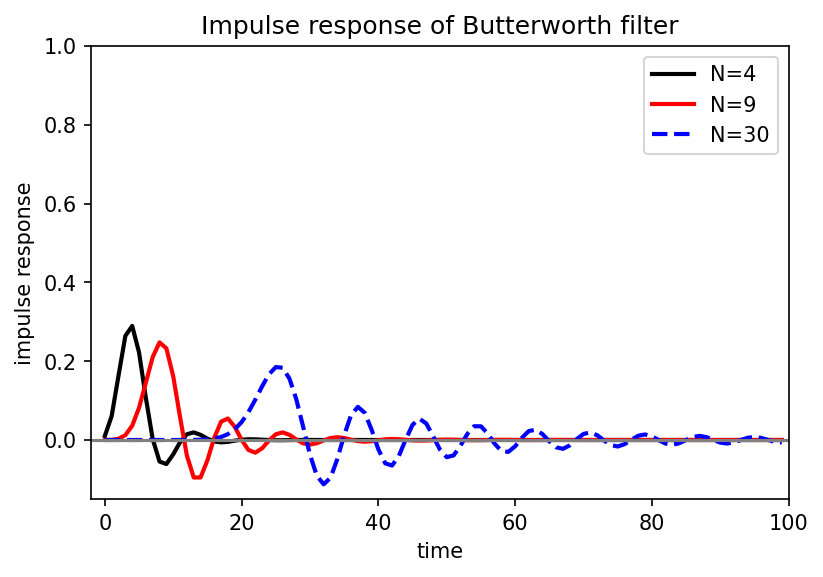

In [11]:
plt.figure()

#**********TRY TO MODIFY**************
# Modify the "N" values below
#*************************************

N = 4
b, a = sig.butter(N, .25)
y = sig.lfilter(b,a,x)
plt.plot(y,'-k',linewidth = 2, label = 'N=' + str(N))

N = 9
b, a = sig.butter(N, .25)
y = sig.lfilter(b,a,x)
plt.plot(y,'-r',linewidth = 2, label = 'N=' + str(N))

N = 30
b, a = sig.butter(N, .25)
y = sig.lfilter(b,a,x)
plt.plot(y,'--b',linewidth = 2, label = 'N=' + str(N))

plt.ylim(-.15,1.)
plt.xlim(-2,100)
plt.axhline(y=0,color='gray')

plt.xlabel('time')
plt.ylabel('impulse response')
plt.title('Impulse response of Butterworth filter')

plt.legend()

plt.show()

You can see that the initial impulse is spread over more future times for larger order N. This means that the beginning of your time series can take some time to _spin-up_ when applying a recursive filter, and thus, will likely need to be discarded since it will be corrupt. So, the larger the order N, the tighter your frequency cutoff, but the more data you have to remove from your time series.

#### Impulse response for impulse at beginning and middle array

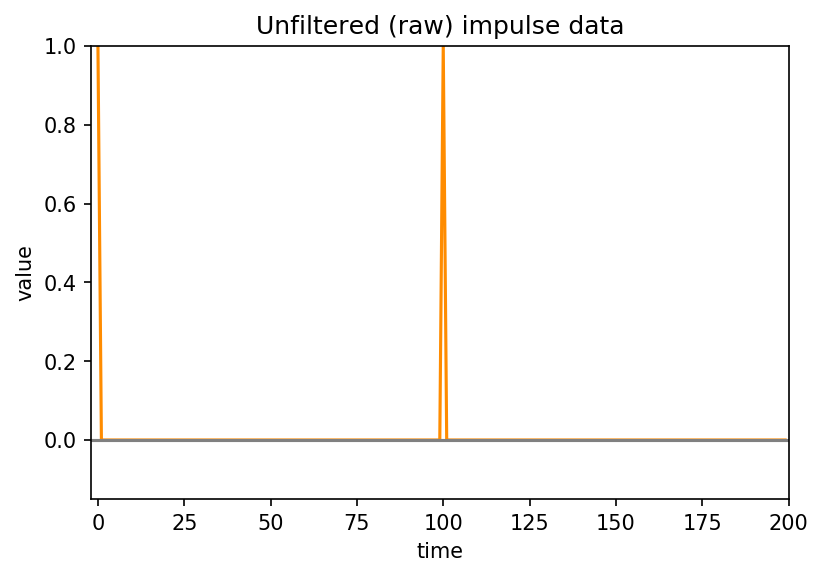

In [0]:
x = np.zeros((200,))
x[0] = 1.
x[100] = 1.

plt.figure()
plt.plot(x, color = 'darkorange')
plt.axhline(y=0,color='gray')
plt.ylim(-.15,1.)
plt.xlim(-2,200)
plt.xlabel('time')
plt.ylabel('value')
plt.title('Unfiltered (raw) impulse data')
plt.show()

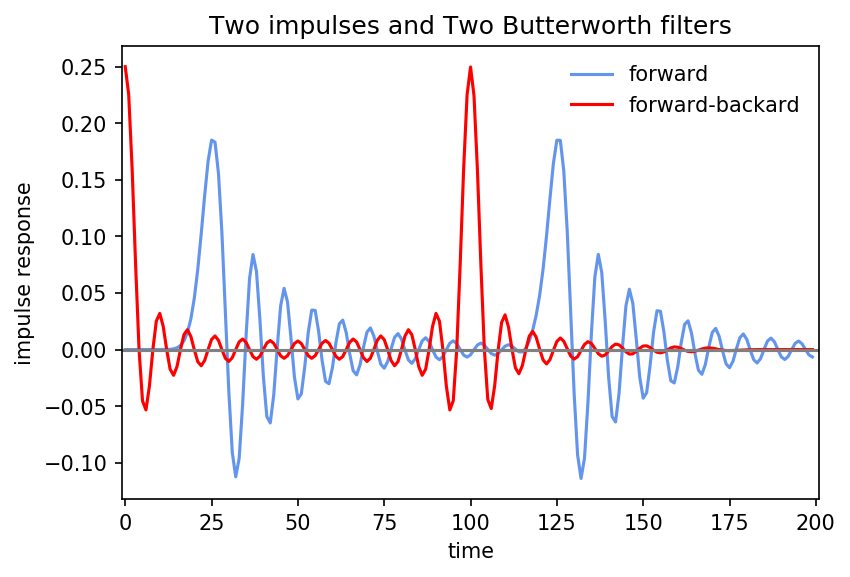

In [0]:
plt.figure()

N = 30
b, a = sig.butter(N, .25)
y = sig.lfilter(b,a,x)
plt.plot(y,'-',color='cornflowerblue',label = 'forward')

y2 = sig.lfilter(b,a,y[::-1])
y2 = y2[::-1]
plt.plot(y2,'-r', label = 'forward-backard')

plt.axhline(y=0,color='gray')

plt.xlabel('time')
plt.ylabel('impulse response')
plt.title('Two impulses and Two Butterworth filters')

plt.xlim(-1,np.size(x)+1)

plt.legend(frameon = False)
plt.show()

#### Butterworth filter applied to red-noise data

Let's apply a Butterworth filter to data that we might actually see in our research, e.g. red noise. First, we need to make the red-noise data (which we all know how to do!). Then, for fun, I'm going to add some cosines to it too to give it some oscillatory frequencies.

In [0]:
chunk_length = 200
num_chunks= 1
n = chunk_length*num_chunks

# generate red noise time series with autocorrelation
alpha = 0.5
height = 2.0
factor = np.sqrt(1.-alpha*alpha)

x = np.zeros((n,))
pnum = 0

# make red-noise + cosine functions
x[0] = x[-1]*alpha + factor*np.random.randn()
for j in np.arange(1,n):
    x[j] = x[j-1]*alpha + factor*np.random.randn()+1.0*np.cos(2.*np.pi*(1.-0.01*np.random.randn())*52./256.*j)\
    + 0.75*np.cos(2.*np.pi*(1.-.001*np.random.randn())*100./256*j-np.pi/4.)
        
xa = x - np.mean(x)

Plot the results!

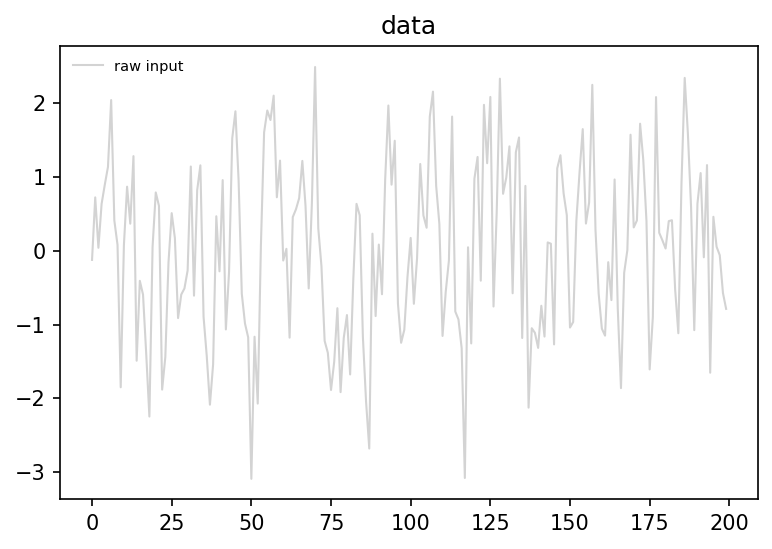

In [0]:
plt.figure()

plt.plot(x,'-',color = 'lightgray',linewidth = 1.0, label = 'raw input')

plt.title('data')
plt.legend(frameon = False, fontsize = 7)
plt.show()

Apply the filters.

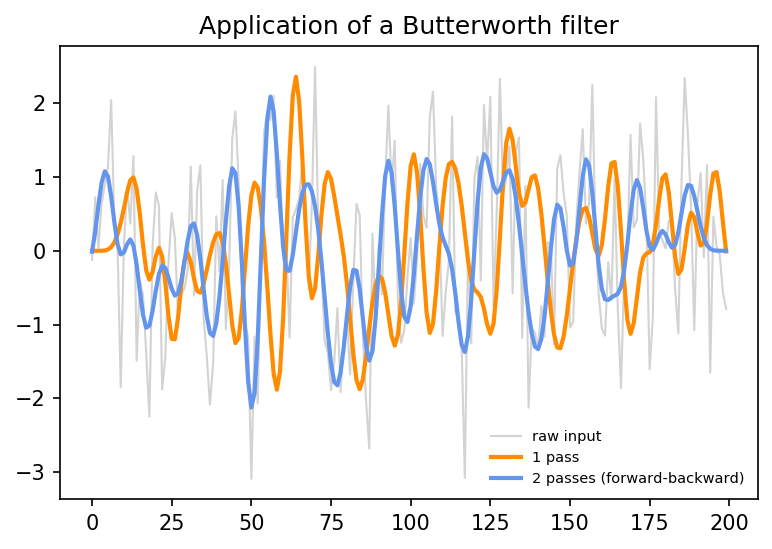

In [0]:
plt.figure()

# create an order=9 butter worth filter with cutoff at frequency = 0.25 and apply it to my data "xa"
N = 9
b, a = sig.butter(N, .25)
y = sig.lfilter(b,a,xa)

plt.plot(x,'-',color = 'lightgray',linewidth = 1.0, label = 'raw input')
plt.plot(y,'-',color = 'darkorange',linewidth = 2.0, label = '1 pass')

# apply the filter to the filtered data, but backward
y2 = sig.lfilter(b,a,y[::-1])
plt.plot(y2[::-1],'-',color = 'cornflowerblue',linewidth = 2.0, label = '2 passes (forward-backward)')

plt.title('Application of a Butterworth filter')

plt.legend(frameon = False, fontsize = 7)
plt.show()

Okay - now let's take _the same time series_ and instead filter it using a 1-2-1 filter (or moving average filter) for comparison.

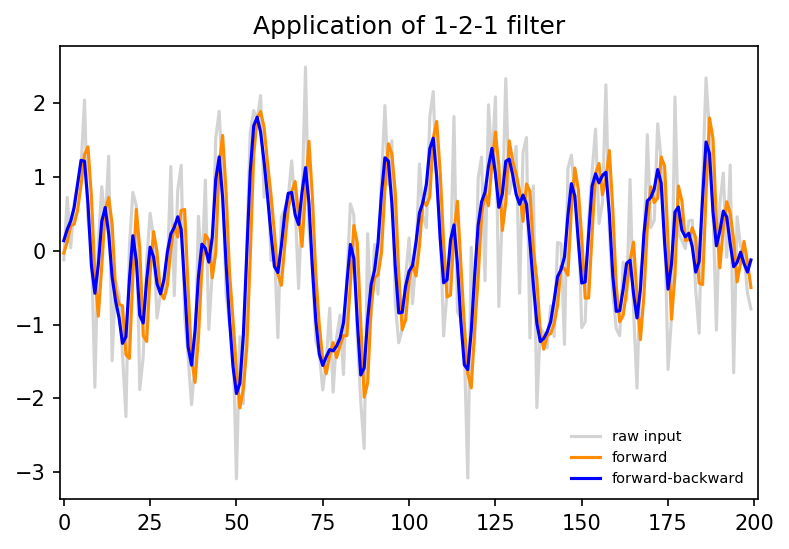

In [0]:
#%% same data, 1-2-1 filter, or moving average filter
plt.figure()
plt.plot(x,'-',color = 'lightgray',linewidth = 1.5, label = 'raw input')

# create and apply 1-2-1 filter
b = (1,2,1)
y = sig.lfilter(b,np.sum(b),x)
plt.plot(y,'-', color = 'darkorange', label = 'forward')

# apply the filter again but to the already filtered data - and backward
y2 = sig.lfilter(b,np.sum(b),y[::-1])

plt.plot(y2[::-1],'-b', label = 'forward-backward')
plt.xlim(-1,np.size(x)+1)

plt.legend(frameon = False, fontsize = 7)

plt.title('Application of 1-2-1 filter')
plt.show()

### Lanczos filter (non-recursive)

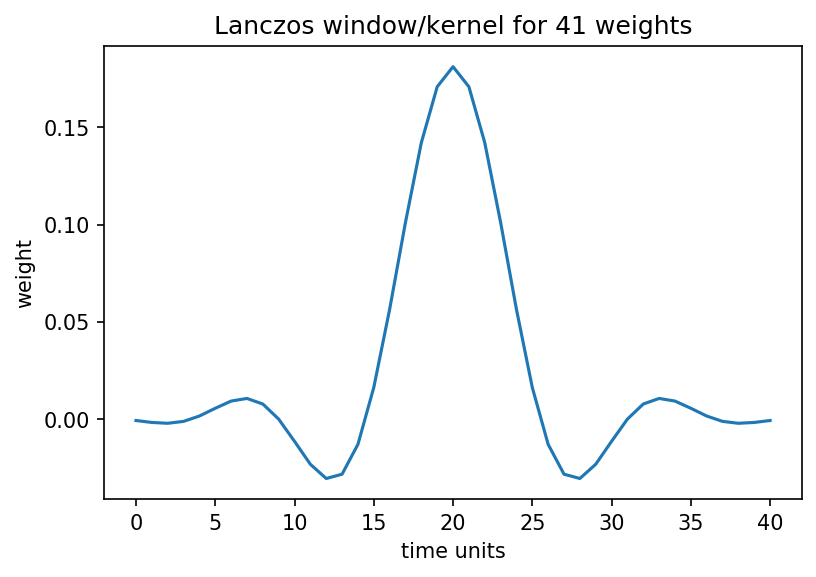

In [0]:
# create Lanczos filter with 41 weights and cutoff at frequency = 1./11.
window = 41
wgts24 = low_pass_weights(window, 1. / 11.)

# plot weights for visualization
plt.figure()
plt.plot(wgts24/np.sum(wgts24))

plt.xlabel('time units')
plt.ylabel('weight')
plt.title('Lanczos window/kernel for ' + str(window) + ' weights')
plt.show()

Now, what happens when we apply this Lanczos filter with 41 weights to our red-noise + cosine time series?

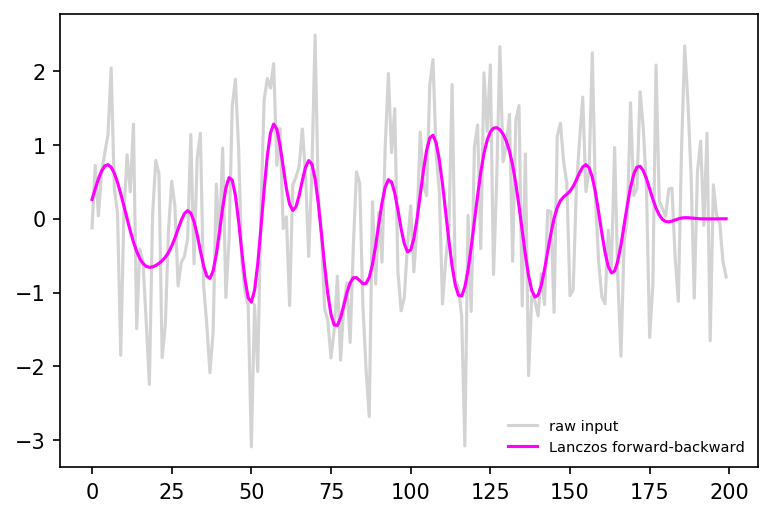

In [0]:
plt.figure()
plt.plot(x,'-',color = 'lightgray',linewidth = 1.5, label = 'raw input')

y = sig.lfilter(wgts24,np.sum(wgts24),x)
y2 = sig.lfilter(wgts24,np.sum(wgts24),y[::-1])
plt.plot(y2[::-1], color = 'fuchsia', label = 'Lanczos forward-backward')

plt.legend(frameon = False, fontsize = 7)
plt.show()

*To see any updated versions of this notebook, visit https://github.com/eabarnes1010/ats655-coursematerial/blob/master/jupyter_notebooks/butterworth_lanczos_example.ipynb*